# Apply statsmodels to the ML model
# Try stacked regression with TensorFlow
# Need to create binary identifier for having an additional dwelling unit.

## Data Exploration/Analysis

Ultimate goal is to predict median sale price per square foot of a house.

Current step: EDA

Next step: PCA and Clustering. See what patterns emerge in the clusters.

Final step: predict median sale price per square foot.

### Try to find a neighborhood of mid-rise somewhere. 
### Find the neighborhood with the highest % 'PLEX'

Questions:

* What's going on with the really pricey outliers?

* What kind of buiding types are in a high-value neighborhood?

* What correlates with high housing prices?
    * Distance from city center? 
    * Neighborhood composition of the buildings (a lot of multi-family or mixture of uses leads to higher PPSF)?
    * Half-baths
    * 
    
* What kind of neighborhoods experience multi-parcel sales?

* How do housing prices change over time?

* How does square footage correlate with price?

* Does population density correlate with price?

* How do building heights correlate with prices?

* Does building frame/exterior wall material affect price in the neighborhood?

* How do we deal with zipcodes?

* How does price per square acre differ from price per square foot?

## Questions to ask Davidson Co:

* 'Fixtures' feature

* Building Grade

* Tax District

* Sold as Vacant

## Observations:

Multifamily is usually listed with a 'Land Area' of 0.

Condos/apartments, no matter how tall their building, are listed with a height of 1 :/

Really need to start dropping extraneous columns, especially 'assessment' and 'appraisal' values and redundant columns.

From what I can tell, all areas near downtown (east, north and west) are gentrifying. The South side was already middle-class.

## Zones for reference:
Note that each zone (except 5) has a part touching downtown then spreads out
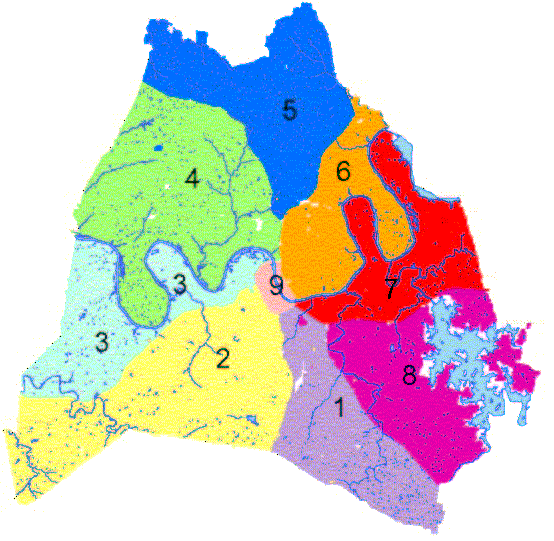

## Neighborhoods (arbitrary/unofficial):

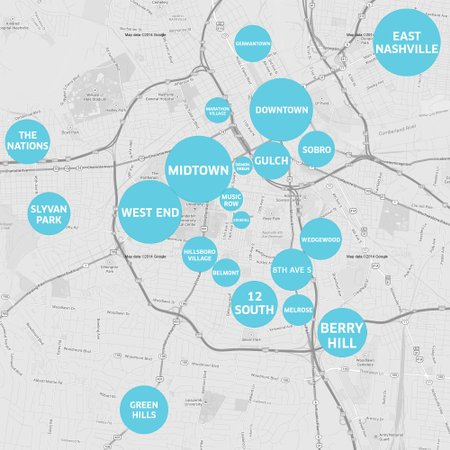

## Zipcodes for Reference
This image is large, but I like the detail. 
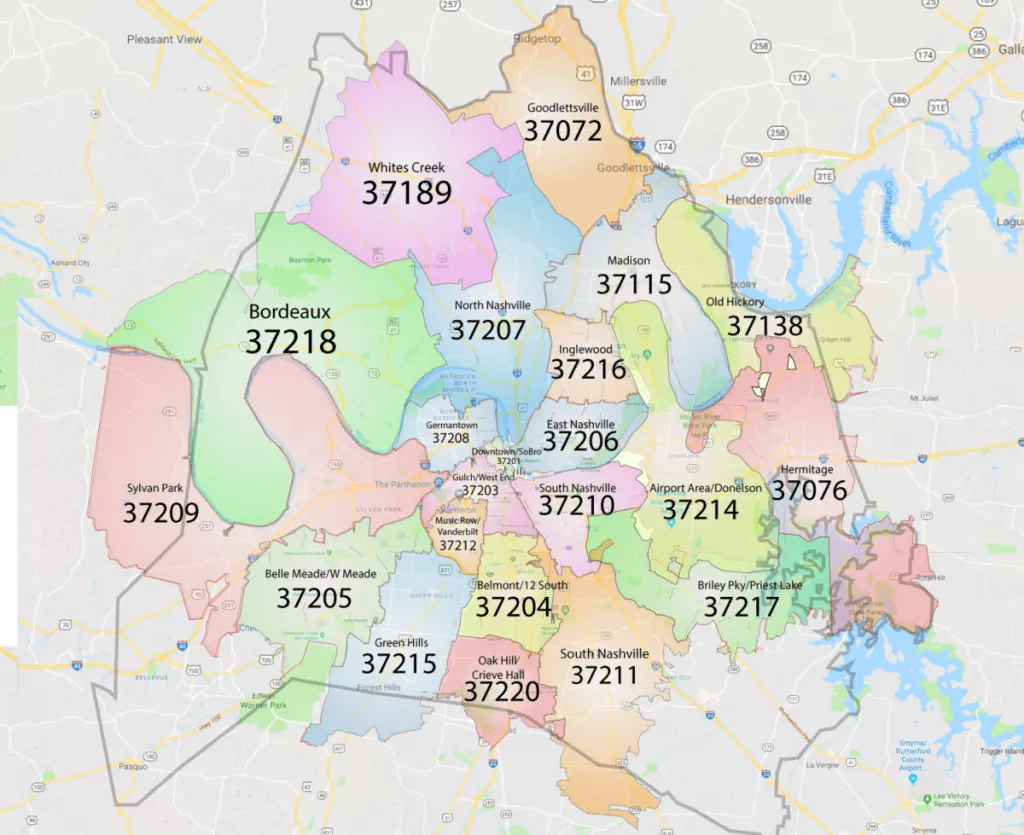

## Motivation

Cities around the sunbelt have been growing the fastest in the US:
https://www.usatoday.com/story/money/2019/05/09/americas-fastest-growing-cities/39442201/

And Nashville is no exception. In fact it's often billed as a 'superstar' city with exemplary economic development that other cities strive for. 

https://www.reuters.com/article/us-usa-economy-nashville-insight/as-u-s-superstar-cities-thrive-weaker-ones-get-left-behind-idUSKCN1UE13B

Like all major Sunbelt cities, it followed a sprawled, "donut" development pattern post-WW2 consisting of primarily suburban growth while the city center declined. Post-Recession growth has been the opposite, seeing far-out "exurb" properties decline while city center development transforms once-neglected, historic neighborhoods.
In this project we want to determine which neighborhoods are experiencing the most growth, and what might be driving that growth. Hopefully this will tell us which neighborhood is ripe for development (or decline). 

https://www.governing.com/gov-data/nashville-gentrification-maps-demographic-data.html

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd 
%matplotlib inline
sns.set(style='darkgrid')

In [36]:
df1=pd.read_csv('nashville_20190827200234.csv', parse_dates = ['Most Recent Sale Date', 'Sale Date'], dtype={'Zone': str, 'Neighborhood': str})

C:\Users\alehe\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df1.columns

Index(['Assessment Classification*', 'Assessment Improvement',
       'Assessment Land', 'Assessment Total', 'Assessment Year', 'Baths',
       'Beds2', 'Building Condition', 'Building Grade2', 'Building Type',
       'Building Type2', 'Current Owner', 'Deed Reference', 'Exterior Wall',
       'Exterior Wall2', 'Fixtures', 'Fixtures2', 'Foundation Type',
       'Foundation Type2', 'Frame Type', 'Half Bath', 'Half Bath2',
       'Improvement Value', 'Land Area', 'Land Value', 'Location',
       'Mailing Address', 'Map & Parcel', 'Most Recent Sale Date',
       'Most Recent Sale Price', 'Neighborhood', 'Number of Living Units',
       'Roof Cover', 'Rooms', 'Rooms2', 'Square Footage', 'Square Footage2',
       'Story Height', 'Story Height2', 'Tax District',
       'Total Appraisal Value', 'Year Built', 'Year Built2', 'Zone',
       'Parcel ID', 'Land Use', 'Property Address', 'Suite/ Condo   #',
       'Property City', 'Sale Date', 'Sale Price', 'Legal Reference',
       'Sold As Vacant

In [44]:
df1.head()

,Unnamed: 0,Assessment Classification*,Assessment Improvement,Assessment Land,Assessment Total,Assessment Year,Baths,Beds,Building Condition,Building Grade,...,Assessment Improvement Improved,Most Recent Sale Price Improved,Improvement Value Improved,Assessment Total Improved,Land Value Improved,Assessment Land Improved,Total Appraisal Value Improved,Square Footage Improved,Building Type Custom,Land Area Acres
0,0,AG/RES,$0,"$2,655","$2,655",2019,NaN,NaN,NaN,NaN,...,2655.0,7500.0,0.0,2655.0,10621.0,2655.0,10621.0,0.0,NaN,7.60
1,1,AG/RES,$0,"$4,081","$4,081",2019,NaN,NaN,NaN,NaN,...,4081.0,12500.0,0.0,4081.0,16323.0,4081.0,16323.0,0.0,NaN,8.90
2,2,EXE,$0,$0,$0,2019,NaN,NaN,NaN,NaN,...,0.0,67000.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2.90
3,3,EXE,$0,$0,$0,2019,2.0,3.0,Poor,E,...,0.0,67000.0,34800.0,0.0,12300.0,0.0,47100.0,1224.0,SINGLE FAM,0.79
4,4,EXE,$0,$0,$0,2019,NaN,NaN,NaN,NaN,...,0.0,67000.0,0.0,0.0,27400.0,0.0,27400.0,0.0,NaN,2.11


## A little data formatting:

In [34]:
#Creating new dataframe without duplicate entires
df=df1.sort_values(by='Sale Date').drop_duplicates(subset='Map & Parcel', keep = 'last')
#Dropping parcels that were involved in multi-parcel sales
df=df[df['Multiple Parcels Involved in Sale'] == 'No']
#Want to create a new column which is the mean sale price per square foot of a parcel in that neighborhood
df['PPS']=df['Sale Price']/df['Square Footage Improved']
df['PPS']=df['PPS'].replace(np.inf, np.nan)
df=df[df['PPS'].notnull()]
#meanpps is a nbhd-wide variable for use in clustering and neighborhood inspection.
meanpps=df.groupby('Neighborhood')['PPS'].mean().to_frame().rename(columns={'PPS':'NeighborhoodPPS'})
df=df.merge(meanpps, how='left', left_on = 'Neighborhood',right_index=True)
#Dropping PPS outliers, because a rare few observations (likely incorrectly-entered data) are skewing the distribution.
df=df[df.PPS <= 1100]

In [35]:
# df['Building Grade']

In [27]:
(df.isna().sum() / len(df)).sort_values(ascending=False)

Half Bath2                           0.995089
Rooms2                               0.994390
Beds2                                0.994390
Fixtures2                            0.994353
Year Built2                          0.994224
Building Type2                       0.994224
Story Height2                        0.994224
Building Grade2                      0.994224
Foundation Type2                     0.994224
Exterior Wall2                       0.994187
Square Footage2                      0.994187
Suite/ Condo   #                     0.888823
Frame Type                           0.192204
Half Bath                            0.007431
Fixtures                             0.000699
Rooms                                0.000497
Foundation Type                      0.000092
Roof Cover                           0.000037
Exterior Wall                        0.000037
Number of Living Units               0.000018
Baths                                0.000018
Most Recent Sale Date             

In [28]:
df1['Roof Cover'].value_counts()
#I think we should test this in the ML model.

ASPHALT         195404
TYPICAL          32076
ROLLED            3771
METAL             2481
SLATE              425
UNKNOWN            384
WOOD               319
TILE               318
TAR + GRAVEL       122
Name: Roof Cover, dtype: int64

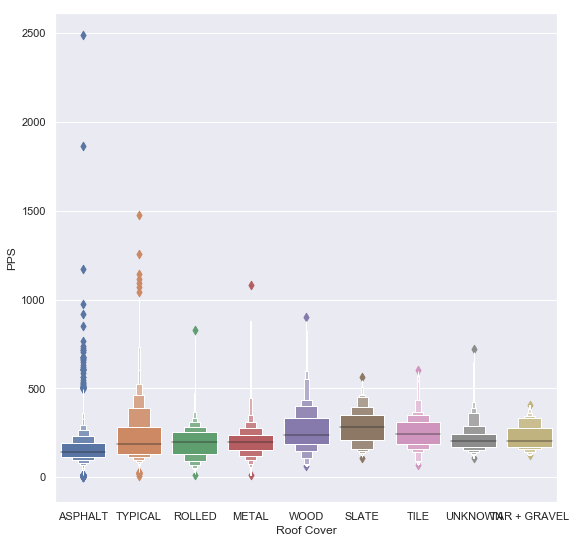

In [33]:
plt.figure(figsize=(9,9))
sns.boxenplot(x='Roof Cover', y = 'PPS', data=df)

In [31]:
df.nlargest(20,'PPS')['Location']

126203               7315 SONYA DR
70794               1401 4TH AVE N
249928    600 12TH AVE S Unit 2216
279746     515 CHURCH ST Unit 4502
93320               300 35TH AVE N
261248    1212 LAUREL ST Unit 2303
279614     515 CHURCH ST Unit 3406
261255    1212 LAUREL ST Unit 2307
106716               6012 HILL CIR
279628     515 CHURCH ST Unit 3506
261179    1212 LAUREL ST Unit 2001
279725     515 CHURCH ST Unit 4304
279704     515 CHURCH ST Unit 4104
113967             1907 CONVENT PL
235871       320 BROADWAY Unit 301
279714     515 CHURCH ST Unit 4204
279730     515 CHURCH ST Unit 4308
279689     515 CHURCH ST Unit 4003
279679     515 CHURCH ST Unit 3904
279718     515 CHURCH ST Unit 4208
Name: Location, dtype: object

Text(0, 0.5, '# Houses')

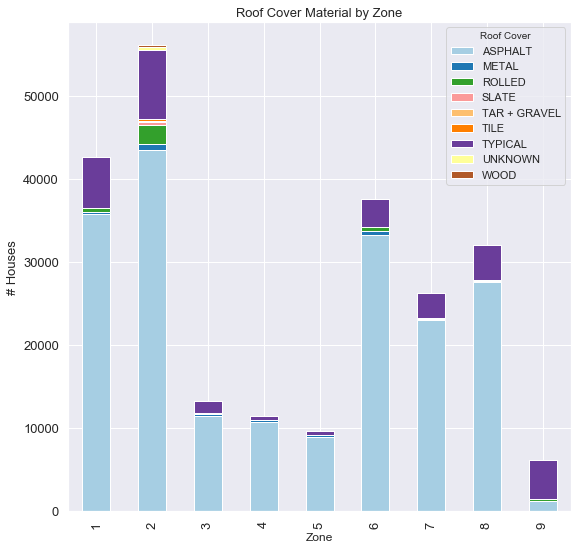

In [10]:
pd.crosstab(df1.Zone,df1['Roof Cover']).plot(kind='bar',stacked=True, colormap='Paired', figsize=(9,9), fontsize=13)
plt.title('Roof Cover Material by Zone', fontsize=13)
plt.ylabel('# Houses', fontsize=13)

### Our goal for this project is to predict price per square foot of a building, and patterns in PPS among neighborhoods.
Let's examine our target variable.

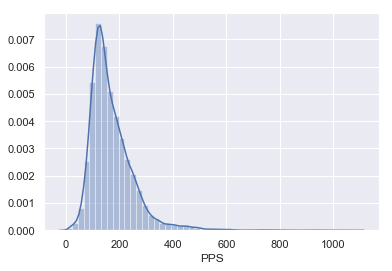

In [18]:
sns.distplot(df['PPS'])

In [19]:
df['PPS'].describe()

count    54357.000000
mean       169.867190
std         83.211278
min          0.027313
25%        115.942029
50%        150.641026
75%        205.790024
max       1091.422702
Name: PPS, dtype: float64

In [20]:
df['PPS'].quantile([.9, .95, .999])

0.900    266.132975
0.950    312.730171
0.999    765.582656
Name: PPS, dtype: float64

Text(0.5, 1.0, 'Median PPS Over Time')

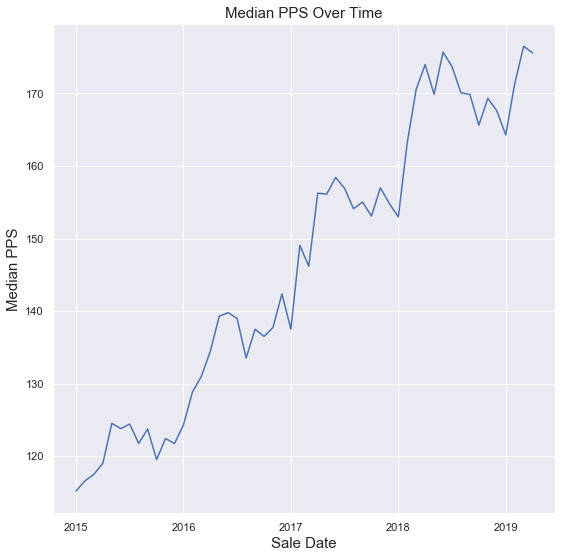

In [21]:
#Plotting average PPS per month
df.groupby(df['Sale Date'].dt.to_period('M'))['PPS'].median().plot(figsize=(9,9))
plt.ylabel('Median PPS', fontsize=15)
plt.xlabel('Sale Date', fontsize=15)
plt.title('Median PPS Over Time', fontsize=15)
#Look for luxury development completed in Jan 2018

Text(0.5, 1.0, 'Median Sale Price Over Time')

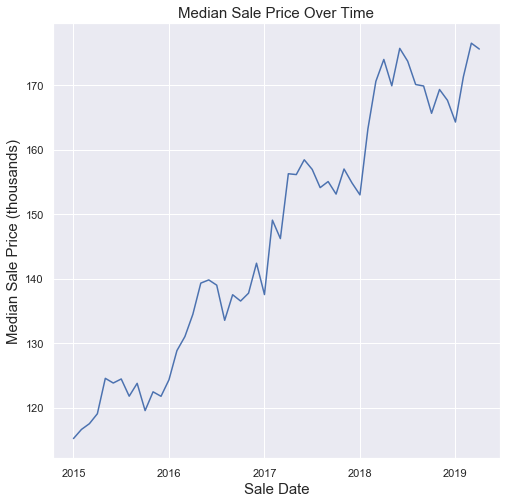

In [22]:
df.groupby(df['Sale Date'].dt.to_period('M'))['PPS'].median().plot(figsize=(8,8))
plt.xlabel('Sale Date', fontsize=15)
plt.ylabel('Median Sale Price (thousands)', fontsize=15)
plt.title('Median Sale Price Over Time', fontsize=15)

Text(0.5, 1.0, 'Sale Count by Month')

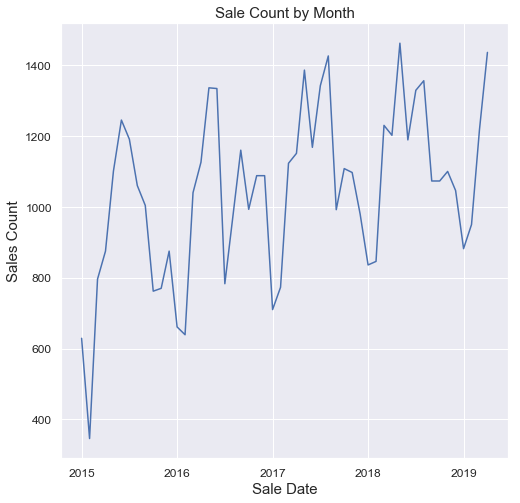

In [23]:
#Note that sale price correlates with the sale volume (exhibits the same seasonality)
df.groupby(df['Sale Date'].dt.to_period('M'))['PPS'].count().plot(fontsize=12, figsize=(8,8))
plt.ylabel('Sales Count', fontsize=15)
plt.xlabel('Sale Date', fontsize=15)
plt.title('Sale Count by Month', fontsize=15)
#Check against another city or housing index, MLS has publicly available data and Redfin to see if the pattern is normal

### Let's examine how PPS is distributed over the *neighborhoods*:
First how many neighborhoods are there?

In [24]:
len(df['Neighborhood'].unique())
#This will be pretty granular. We should consider trends among Zones as well.

814

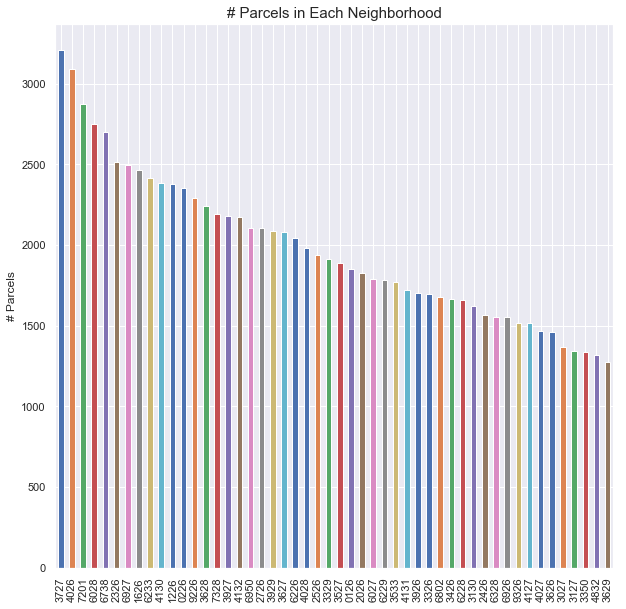

In [49]:
plt.figure(figsize=(10,10))
df1.Neighborhood.value_counts()[:50].plot('bar')
plt.title("# Parcels in Each Neighborhood", fontsize=15)
plt.ylabel('# Parcels')
plt.show()
#Nice even class distribution

In [8]:
df['NeighborhoodPPS'].describe()

count    54233.000000
mean       174.838312
std         80.669206
min         35.235169
25%        121.362586
50%        147.214679
75%        201.106520
max       1169.199296
Name: NeighborhoodPPS, dtype: float64

Text(0.5, 1.0, 'Average PPS across Neighborhoods')

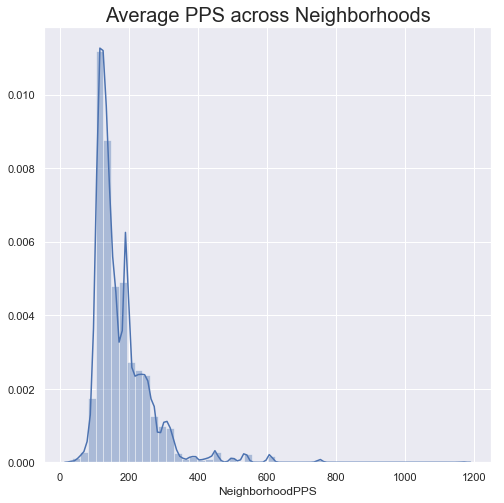

In [9]:
plt.figure(figsize=(8,8))
sns.distplot(df['NeighborhoodPPS'].dropna())
plt.title('Average PPS across Neighborhoods', fontsize=20)

In [62]:
#The most expensive neighborhoods
meanpps.nlargest(15,'NeighborhoodPPS')
#9527 is throwing off results. Remember to examine 6011 as well.

,NeighborhoodPPS
Neighborhood,
9527,1169.199296
6264,752.879821
9026,609.146870
6011,602.827175
6442,536.781227
6375,523.752618
4267,506.597339
4098,495.971656
6444,463.819647


In [35]:
#Priciest neighborhood in the dataset. 
#Only 12 houses and very similar to Belle Meade (luxury single-family detached on large lots).
df9527=df[df['Neighborhood']=='9527']
df9527.describe()

,Unnamed: 0,Assessment Year,Baths,Beds,Fixtures,Half Bath,Number of Living Units,Rooms,Story Height,Year Built,...,Land Value Improved,Assessment Land Improved,Total Appraisal Value Improved,Square Footage Improved,Land Area Acres,PPS,NeighborhoodPPS,Ratio2,Assessment Ratio,Log Fixtures
count,9.000000,9.0,9.000000,9.000000,9.000000,9.000000,9.0,9.000000,9.000000,9.000000,...,9.000000e+00,9.000000,9.000000e+00,9.000000,9.000000,9.000000,9.000000e+00,9.000000,9.000000,9.000000
mean,152243.555556,2019.0,4.000000,4.444444,16.000000,0.666667,1.0,9.000000,1.444444,1951.666667,...,5.417444e+05,135436.111111,1.491700e+06,4636.666667,2.564444,404.284927,1.169199e+03,0.107446,0.429785,2.631931
std,5469.302449,0.0,2.291288,2.603417,9.219544,0.866025,0.0,3.316625,0.527046,30.450780,...,2.577678e+05,64441.939846,1.090111e+06,2493.602063,2.218052,403.294588,2.411662e-13,0.034870,0.139480,0.568224
min,137672.000000,2019.0,1.000000,2.000000,5.000000,0.000000,1.0,5.000000,1.000000,1899.000000,...,3.500000e+05,87500.000000,5.190000e+05,832.000000,0.960000,153.637351,1.169199e+03,0.051418,0.205672,1.609438
25%,153730.000000,2019.0,3.000000,3.000000,10.000000,0.000000,1.0,7.000000,1.000000,1937.000000,...,3.599000e+05,89975.000000,8.712000e+05,3684.000000,1.170000,209.815951,1.169199e+03,0.091855,0.367420,2.302585
50%,153988.000000,2019.0,4.000000,4.000000,13.000000,0.000000,1.0,9.000000,1.000000,1958.000000,...,5.350000e+05,133750.000000,9.116000e+05,4239.000000,2.130000,294.880868,1.169199e+03,0.103277,0.413108,2.564949
75%,154259.000000,2019.0,5.000000,4.000000,18.000000,1.000000,1.0,9.000000,2.000000,1961.000000,...,5.699000e+05,142475.000000,1.456100e+06,4703.000000,2.440000,320.341698,1.169199e+03,0.114053,0.456212,2.890372
max,154341.000000,2019.0,9.000000,11.000000,35.000000,2.000000,1.0,16.000000,2.000000,2010.000000,...,1.160700e+06,290175.000000,3.582200e+06,9365.000000,8.120000,1442.307692,1.169199e+03,0.168593,0.674374,3.555348


In [36]:
df9527['Building Type Custom'].value_counts()
#All SFR

SINGLE FAM    11
Name: Building Type Custom, dtype: int64

In [38]:
df9527.sort_values(by='PPS')[['PPS', 'Sale Date', 'Zone', 'Year Built', 'Location', 'Land Area Acres', 'Sale Price', 'Square Footage Improved']]
#Large acreage drives up the PPS metric of the house. So does historicity.
#However, the largest PPS observation has incorrectly-entered square footage. 

,PPS,Sale Date,Zone,Year Built,Location,Land Area Acres,Sale Price,Square Footage Improved
154259,153.637351,2016-12-09,2,1958.0,4419 CURTISWOOD CIR,0.96,566000.0,3684.0
154254,191.579843,2018-07-02,2,1958.0,4401 CURTISWOOD CIR,1.17,901000.0,4703.0
137672,209.815951,2017-01-06,2,1932.0,3506 FRANKLIN PIKE,2.44,855000.0,4075.0
154260,210.275063,2016-08-16,2,1961.0,4421 CURTISWOOD CIR,1.03,925000.0,4399.0
153719,294.880868,2017-08-31,2,1940.0,4002 NEWMAN PL,1.59,1250000.0,4239.0
153988,305.115797,2016-08-22,2,1899.0,4220 FRANKLIN PIKE,2.13,882700.0,2893.0
153969,320.341698,2017-10-05,2,1970.0,4121 FRANKLIN PIKE,8.12,3000000.0,9365.0
154341,510.610080,2017-09-26,2,2010.0,4400 FRANKLIN PIKE,3.23,3850000.0,7540.0
153730,1442.307692,2017-02-01,2,1937.0,4011 FRANKLIN PIKE,2.41,1200000.0,832.0


In [64]:
#9026 contains the highest PPS observations.
df9026= df[df['Neighborhood']=='9026']
df9026.nlargest(15, 'PPS')\
[['PPS', 'Sale Date', 'Zone', 'Year Built', 'Location', 'Square Footage Improved', 'Sale Price']]\
.sort_values(by='PPS', ascending = False)
#Lots of incorrectly-entered square footage throwing off our most important metric.
#4401 Tyne Blvd is actually 6,751 sq ft.
#215 Lynnwood Ter is actually 5,185 sq ft., etc.

,PPS,Sale Date,Zone,Year Built,Location,Square Footage Improved,Sale Price
149710,1903.409091,2015-06-24,2,2009.0,4401 TYNE BLVD,880.0,1675000.0
148702,1788.856305,2018-05-16,2,1900.0,705 BELLE MEADE BLVD,1023.0,1830000.0
128859,1592.592593,2018-08-28,2,1928.0,215 LYNNWOOD TER,675.0,1075000.0
148779,1076.076076,2016-12-22,2,2019.0,4405 SHEPARD PL,999.0,1075000.0
130233,901.604430,2018-03-01,2,2016.0,511 BELLE MEADE BLVD,7043.0,6350000.0
130295,597.510373,2018-08-01,2,2003.0,428 WESTVIEW AVE,6025.0,3600000.0
149231,504.613610,2018-05-15,2,1949.0,408 W BROOKFIELD AVE,6936.0,3500000.0
128870,494.264627,2018-05-02,2,2011.0,201 LYNNWOOD BLVD,5623.0,2779250.0
129579,484.348834,2018-07-13,2,1937.0,411 ELLENDALE AVE,7763.0,3760000.0
149244,469.672157,2019-04-12,2,2019.0,403 W BROOKFIELD AVE,3825.0,1796496.0


In [43]:
df9026[['Location', 'Sale Price', 'PPS', 'Zone']].head(15)
#This is a neighborhood of huge houses, probably owned by country musicians. 
#It's called "Belle Meade" in SW Nashville
#Zone 2 is the highest-population zone.

,Location,Sale Price,PPS,Zone
129481,306 JACKSON BLVD,660000.0,158.653846,2
148364,605 LYNNWOOD BLVD,892000.0,227.667177,2
129653,332 WALNUT DR,532500.0,153.946227,2
148399,615 WESTVIEW AVE,1475000.0,190.298026,2
130343,4324 SIGNAL HILL DR,986000.0,244.665012,2
148322,4312 SUNNYBROOK DR,400000.0,343.642612,2
149399,807 LYNNWOOD BLVD,515000.0,198.000769,2
149393,907 LYNNWOOD BLVD,505000.0,248.768473,2
129673,404 LYNNWOOD BLVD,700000.0,107.609531,2
148346,617 ROYAL OAKS PL,679240.0,203.122010,2


In [15]:
df9026.describe()
#Mean sale price of #1.44 million, mean PPS of $609.  

,Unnamed: 0,Assessment Year,Baths,Beds,Fixtures,Half Bath,Number of Living Units,Rooms,Story Height,Year Built,...,Most Recent Sale Price Improved,Improvement Value Improved,Assessment Total Improved,Land Value Improved,Assessment Land Improved,Total Appraisal Value Improved,Square Footage Improved,Land Area Acres,PPS,NeighborhoodPPS
count,206.000000,206.0,206.000000,206.000000,206.000000,205.000000,206.0,206.000000,206.000000,206.000000,...,2.060000e+02,2.060000e+02,2.060000e+02,2.060000e+02,206.000000,2.060000e+02,206.000000,206.000000,206.000000,2.060000e+02
mean,141964.810680,2019.0,4.121359,4.257282,17.849515,0.692683,1.0,10.281553,1.655340,1968.577670,...,1.433861e+06,8.774898e+05,4.071408e+05,7.510733e+05,187768.325243,1.628563e+06,5067.388350,1.035243,321.695945,6.091469e+02
std,16093.097925,0.0,1.393305,1.053135,5.842792,0.821402,0.0,2.816043,0.414106,31.789572,...,9.239642e+05,6.608319e+05,2.060443e+05,2.500062e+05,62501.559598,8.241773e+05,2105.548402,0.794607,207.319296,4.558551e-13
min,128189.000000,2019.0,1.000000,1.000000,5.000000,0.000000,1.0,2.000000,1.000000,1900.000000,...,0.000000e+00,4.860000e+04,1.184750e+05,4.050000e+05,101250.000000,4.739000e+05,675.000000,0.290000,61.258705,6.091469e+02
25%,129638.750000,2019.0,3.000000,4.000000,14.000000,0.000000,1.0,9.000000,1.125000,1940.750000,...,8.861875e+05,3.557750e+05,2.604562e+05,5.610000e+05,140250.000000,1.041825e+06,3742.500000,0.595000,248.362331,6.091469e+02
50%,148322.500000,2019.0,4.000000,4.000000,18.000000,0.000000,1.0,10.000000,1.750000,1961.000000,...,1.300000e+06,7.709000e+05,3.542125e+05,7.474000e+05,186850.000000,1.416850e+06,4832.500000,0.920000,301.466810,6.091469e+02
75%,149248.500000,2019.0,5.000000,5.000000,22.000000,1.000000,1.0,12.000000,2.000000,1999.750000,...,1.828750e+06,1.175550e+06,5.050812e+05,8.910000e+05,222750.000000,2.020325e+06,6156.250000,1.167500,343.541626,6.091469e+02
max,262816.000000,2019.0,7.000000,7.000000,32.000000,3.000000,1.0,26.000000,2.500000,2019.000000,...,6.350000e+06,3.688300e+06,1.324675e+06,2.444400e+06,611100.000000,5.298700e+06,14143.000000,8.900000,1903.409091,6.091469e+02


In [31]:
df6264 = df[df.Neighborhood == '6264']
df6264.describe()
#Average sale price of $742.4k

,Unnamed: 0,Assessment Year,Baths,Beds,Fixtures,Half Bath,Number of Living Units,Rooms,Story Height,Year Built,...,Most Recent Sale Price Improved,Improvement Value Improved,Assessment Total Improved,Land Value Improved,Assessment Land Improved,Total Appraisal Value Improved,Square Footage Improved,Land Area Acres,PPS,NeighborhoodPPS
count,76.000000,76.0,76.000000,76.000000,76.000000,76.000000,76.0,76.000000,76.000000,76.0,...,7.600000e+01,7.600000e+01,7.600000e+01,76.000000,76.000000,7.600000e+01,76.000000,76.0,76.000000,7.600000e+01
mean,279658.565789,2019.0,1.328947,1.184211,6.144737,0.013158,1.0,2.184211,1.013158,2018.0,...,6.664474e+05,5.869342e+05,1.821447e+05,141644.736842,35411.184211,7.285789e+05,923.328947,0.0,752.879821,7.528798e+02
std,55.003596,0.0,0.640586,0.604660,1.916274,0.114708,0.0,0.604660,0.114708,0.0,...,6.654020e+05,6.438522e+05,1.715235e+05,46686.101843,11671.525461,6.860940e+05,470.518760,0.0,160.096182,8.010957e-13
min,279552.000000,2019.0,0.000000,0.000000,5.000000,0.000000,1.0,1.000000,1.000000,2018.0,...,0.000000e+00,2.357000e+05,8.392500e+04,100000.000000,25000.000000,3.357000e+05,513.000000,0.0,497.866287,7.528798e+02
25%,279625.250000,2019.0,1.000000,1.000000,5.000000,0.000000,1.0,2.000000,1.000000,2018.0,...,3.987500e+05,3.493000e+05,1.158188e+05,125000.000000,31250.000000,4.632750e+05,703.000000,0.0,609.634551,7.528798e+02
50%,279655.500000,2019.0,1.000000,1.000000,5.000000,0.000000,1.0,2.000000,1.000000,2018.0,...,5.600000e+05,4.180500e+05,1.358875e+05,135000.000000,33750.000000,5.435500e+05,814.000000,0.0,750.159684,7.528798e+02
75%,279709.750000,2019.0,2.000000,2.000000,8.000000,0.000000,1.0,3.000000,1.000000,2018.0,...,7.100000e+05,7.876000e+05,2.359625e+05,156250.000000,39062.500000,9.438500e+05,1057.250000,0.0,890.944115,7.528798e+02
max,279745.000000,2019.0,5.000000,2.000000,14.000000,1.000000,1.0,3.000000,2.000000,2018.0,...,5.500000e+06,5.639400e+06,1.534850e+06,500000.000000,125000.000000,6.139400e+06,4375.000000,0.0,1257.142857,7.528798e+02


In [28]:
df6264.sort_values(by='PPS', ascending=False)[['PPS', 'Sale Price', 'Location', 'Building Type', 'Zone', 'Sale Date']].head()

,PPS,Sale Price,Location,Building Type,Zone,Sale Date
279745,1257.142857,5500000.0,515 CHURCH ST Unit 4502,HRISE CONDO,9,2018-10-15
279613,1115.859449,1175000.0,515 CHURCH ST Unit 3406,HRISE CONDO,9,2019-04-17
279627,1068.376068,1125000.0,515 CHURCH ST Unit 3506,HRISE CONDO,9,2019-03-15
279724,1010.598032,1335000.0,515 CHURCH ST Unit 4304,HRISE CONDO,9,2018-10-12
279703,1010.598032,1335000.0,515 CHURCH ST Unit 4104,HRISE CONDO,9,2018-11-30


In [26]:
print(df6264['Building Type'].value_counts())
#The only thing in this 'neighborhood' is one luxury condo building downtown.
#This is possibly the reason for the spike in price early 2018. 

HRISE CONDO    76
Name: Building Type, dtype: int64


## Zone-wide trends:
Notice that Zone 9 has the lowest count. Does that mean there's development potential?

2    66705
1    48119
6    44224
8    36233
7    29560
3    18146
4    15372
5    12161
9     8700
Name: Zone, dtype: int64


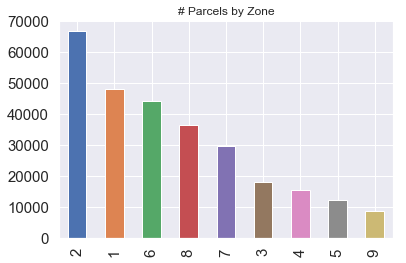

In [11]:
df1.Zone.value_counts().plot('bar', title= '# Parcels by Zone', fontsize=15)
print(df1.Zone.value_counts())

Text(0.5, 1.0, 'Building Types by Zone')

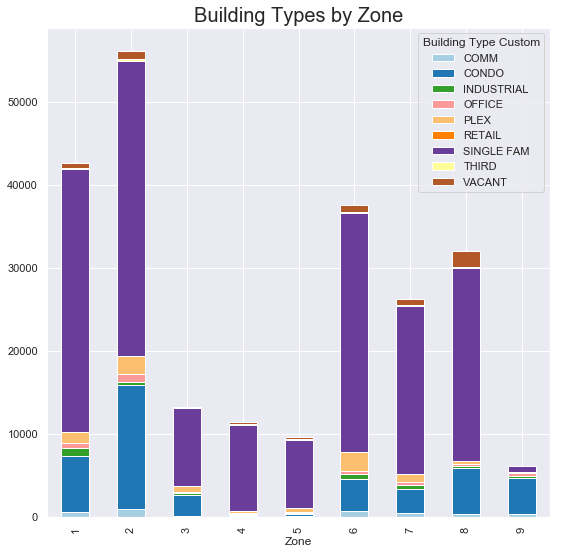

In [93]:
pd.crosstab(df1.Zone,df1['Building Type Custom']).plot(kind='bar',stacked=True, colormap='Paired', figsize=(9,9))
plt.title('Building Types by Zone', fontsize=20)

Text(0.5, 1.0, 'Year Built Distribution by Zone')

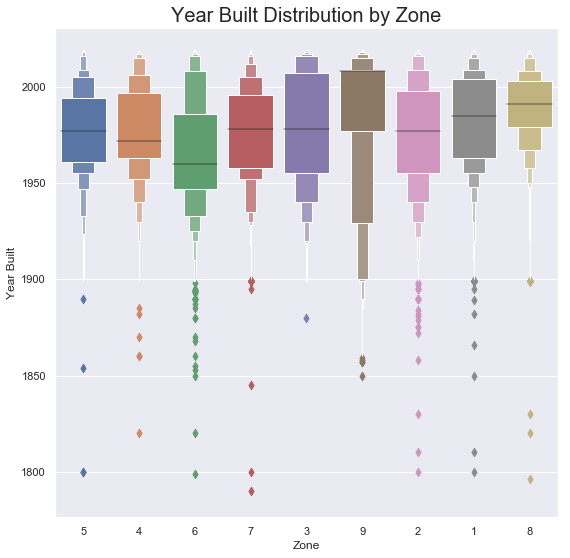

In [97]:
plt.figure(figsize=(9,9))
sns.boxenplot(x="Zone", y="Year Built", data=df1, fontsize=15)
plt.title('Year Built Distribution by Zone', fontsize=20)
#Zone 6 is showing the broadest range of values and the oldest. Perhaps it experienced gentrification at times in the past.
#Zone 9 shows the most recently-built units, but with lots of old historic stuff.
#Zone 8 shows the 2nd-most recent distribution of homes. This would reflect east nashville gentrifying.

Text(0.5, 1.0, 'Price distribution among zones')

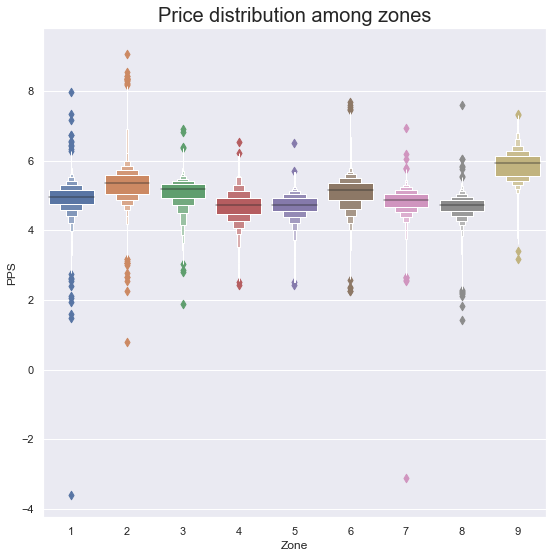

In [12]:
#Showing the price distribution among different zones, but we could use this style graph for any kind of feature.
plt.figure(figsize=(9,9))
sns.boxenplot(x="Zone", y=np.log(df["PPS"]), data=df)
plt.title("Price distribution among zones", fontsize=20)
#Zone 9, the downtown, shows the highest sale prices

## Examining Zone 1

In [99]:
dfz1=df1[df1.Zone=='1']

dfz1['Neighborhood'].unique()

array(['3108', '1426', '3112', '3107', '3111', '3127', '3130', '3113',
       '3132', '9112', '9126', '3106', '3126', '3179', '3135', '3131',
       '3133', '4012', '4026', '4011', '3926', '3134', '4035', '3936',
       '3943', '3911', '3940', '3927', '4028', '4031', '4039', '4036',
       '3944', '4030', '4032', '4047', '4048', '4015', '4041', '3928',
       '3929', '4027', '4227', '4064', '4033', '4040', '4065', '4001',
       '6302', '4038', '4061', '4046', '4045', '4067', '4029', '4043',
       '4037', '4049', '4050', '4079', '6327', '4076', '3947', '3946',
       '3945', '3935', '3932', '3934', '3933', '4052', '3931', '3937',
       '4042', '3758', '4059', '4066', '4054', '6430', '4069', '6427',
       '6431', '6331', '4056', '4062', '4055', '6428', '4075', '6432',
       '4187', '4070', '4058', '4060', '6434', '4073', '4053', '4097',
       '4229', '6433', '4071', '4068', '4077', '4183', '4078', '4080',
       '4081', '4083', '4082', '4232', '4084', '4086', '4093', '4096',
      

## Examining Zone 2
This is by far the largest zone, it also has the priciest neighborhoods.

(66705, 56)


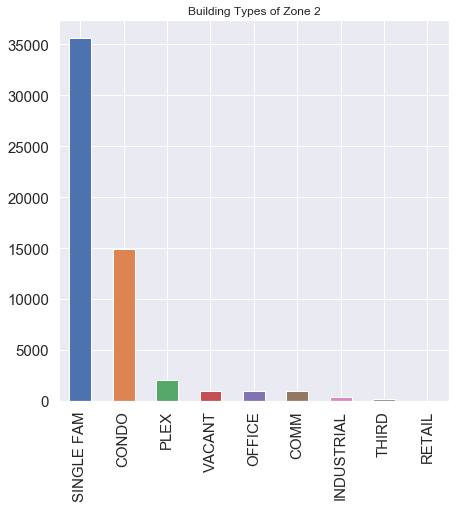

In [28]:
dfz2=df1[df1.Zone=='2']
dfz2['Building Type Custom'].value_counts().plot('bar', title = 'Building Types of Zone 2',figsize=(7,7), fontsize=15)
print(dfz2.shape)

Text(0.5, 1.0, 'Year Built of Buildings in Zone 2')

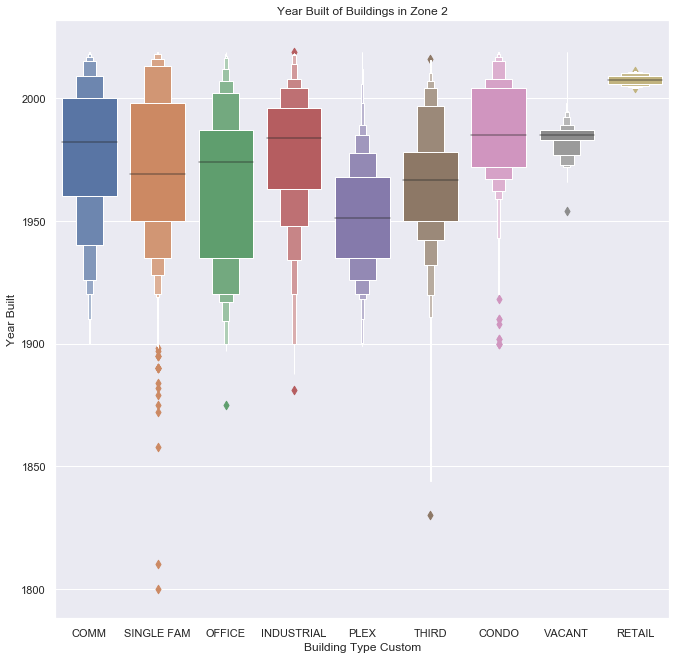

In [75]:
#When were the houses in Zone 2 built, and what type?
plt.figure(figsize=(11,11))
sns.boxenplot(y=dfz2['Year Built'],x=dfz2['Building Type Custom'])
plt.title('Year Built of Buildings in Zone 2')

In [50]:
#Is historicity the reason for Zone 2's higher prices?
dfz2['Year Built'].describe()

count    56126.000000
mean      1975.504561
std         27.803821
min       1800.000000
25%       1955.000000
50%       1977.000000
75%       1998.000000
max       2019.000000
Name: Year Built, dtype: float64

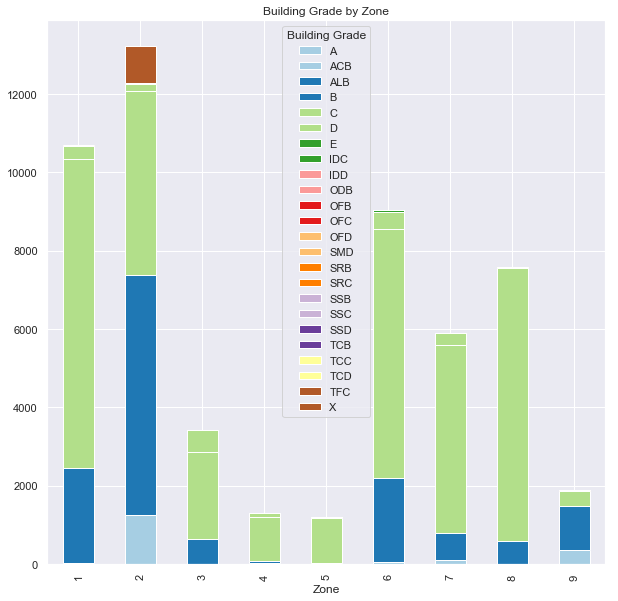

In [95]:
#Want to graph building grade by zone

pd.crosstab(df.Zone, df['Building Grade']).plot(kind='bar',stacked=True, title= 'Building Grade by Zone', colormap='Paired', figsize=(10,10));

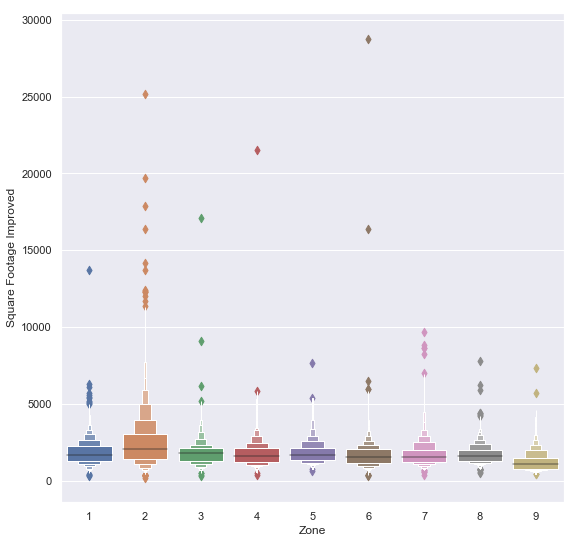

In [60]:
plt.figure(figsize=(9,9))
sns.boxenplot(y=df['Square Footage Improved'],x= df['Zone'])

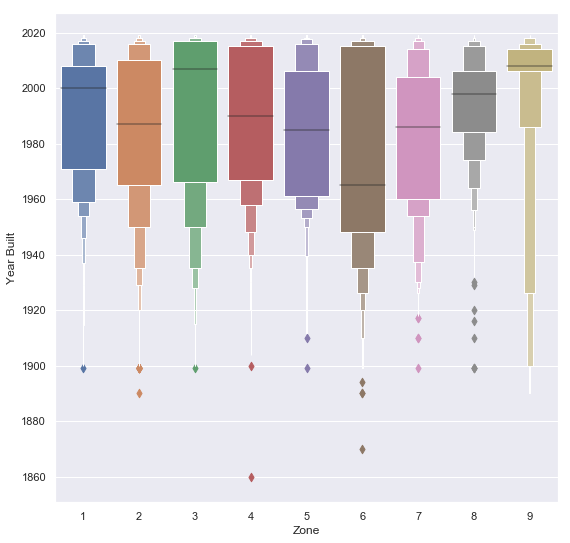

In [54]:
plt.figure(figsize=(9,9))
sns.boxenplot(y=df['Year Built'],x=df['Zone'])
#Well, it appears middle-of-the-road for age of the houses.

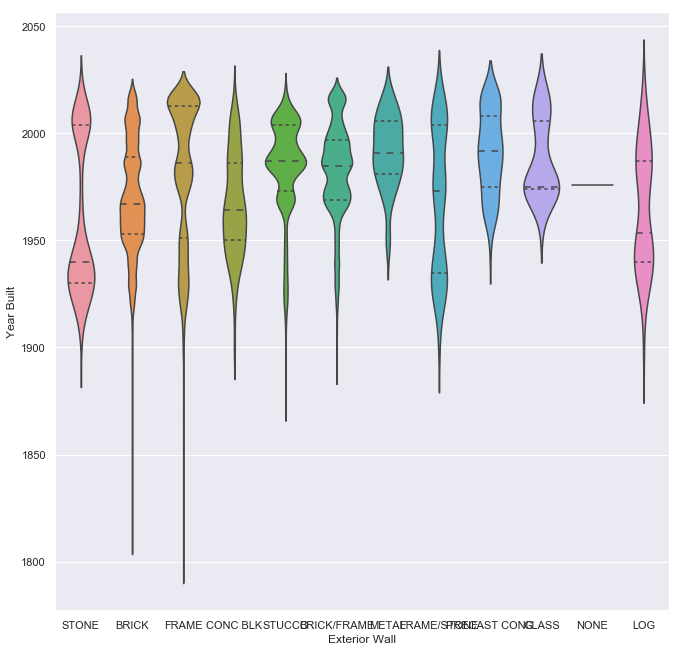

In [70]:
plt.figure(figsize=(11,11))
sns.violinplot(y=dfz2['Year Built'],x=dfz2['Exterior Wall'], inner = 'quartile')

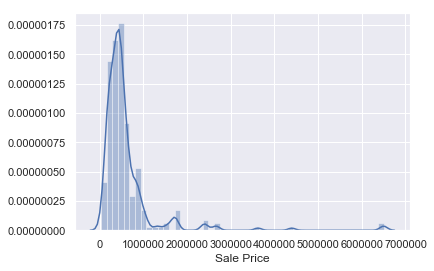

In [80]:
data=dfz2[dfz2['Building Type Custom']=='PLEX']
sns.distplot(data['Sale Price'].dropna())

In [77]:
dfz2.describe()
#This is by far the largest Zone.

,Unnamed: 0,Assessment Year,Baths,Beds,Fixtures,Half Bath,Number of Living Units,Rooms,Story Height,Year Built,Sale Price,Assessment Improvement Improved,Most Recent Sale Price Improved,Improvement Value Improved,Assessment Total Improved,Land Value Improved,Assessment Land Improved,Total Appraisal Value Improved,Square Footage Improved,Land Area Acres
count,66705.000000,66705.0,59352.000000,55590.000000,55332.000000,59169.000000,59398.000000,55590.000000,56126.00000,56126.000000,1.693400e+04,6.666600e+04,6.670500e+04,6.666500e+04,6.666600e+04,6.666500e+04,6.666600e+04,6.666500e+04,66705.000000,66705.000000
mean,162535.242800,2019.0,2.124629,2.936589,10.467722,0.340144,1.780211,7.879888,1.49698,1975.504561,5.469172e+05,6.699601e+04,3.996505e+05,4.114522e+05,1.804429e+05,2.748442e+05,6.699601e+04,6.862964e+05,2561.038918,0.858801
std,54663.230284,0.0,1.283526,1.247404,5.094831,0.555168,20.516030,180.155703,0.60600,27.803821,5.756504e+05,2.631186e+05,3.087851e+06,2.704983e+06,1.111603e+06,3.202955e+06,2.631186e+05,4.966334e+06,8619.503524,9.943555
min,67892.000000,2019.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,1800.000000,9.000000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,116933.000000,2019.0,1.000000,2.000000,8.000000,0.000000,1.000000,5.000000,1.00000,1955.000000,2.599000e+05,1.250000e+04,0.000000e+00,1.193000e+05,5.430000e+04,5.200000e+04,1.250000e+04,2.188000e+05,1010.000000,0.000000
50%,149238.000000,2019.0,2.000000,3.000000,10.000000,0.000000,1.000000,7.000000,1.50000,1977.000000,4.000000e+05,3.125000e+04,1.865000e+05,2.085000e+05,9.116250e+04,1.360000e+05,3.125000e+04,3.613000e+05,1824.000000,0.210000
75%,190269.000000,2019.0,3.000000,4.000000,13.000000,1.000000,1.000000,8.000000,2.00000,1998.000000,6.450000e+05,6.600000e+04,4.040000e+05,3.518000e+05,1.528950e+05,2.600000e+05,6.600000e+04,6.011000e+05,2856.000000,0.500000
max,281886.000000,2019.0,12.000000,18.000000,50.000000,10.000000,2798.000000,29241.000000,19.00000,2019.000000,7.200000e+06,2.469852e+07,3.900000e+08,2.818582e+08,1.374418e+08,7.183044e+08,2.469852e+07,9.264733e+08,661396.000000,1986.600000


SINGLE FAM    23276
CONDO          5525
VACANT         1981
PLEX            431
COMM            332
INDUSTRIAL      321
OFFICE          162
THIRD            76
RETAIL            1
Name: Building Type Custom, dtype: int64 (36233, 56)


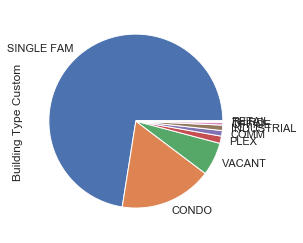

In [6]:
#South suburban zone. In between Downtown, a Lake, and Brentwood.
dfz8=df1[df1.Zone=='8']

dfz8['Building Type Custom'].value_counts().plot.pie()
print(dfz8['Building Type Custom'].value_counts(), dfz8.shape)

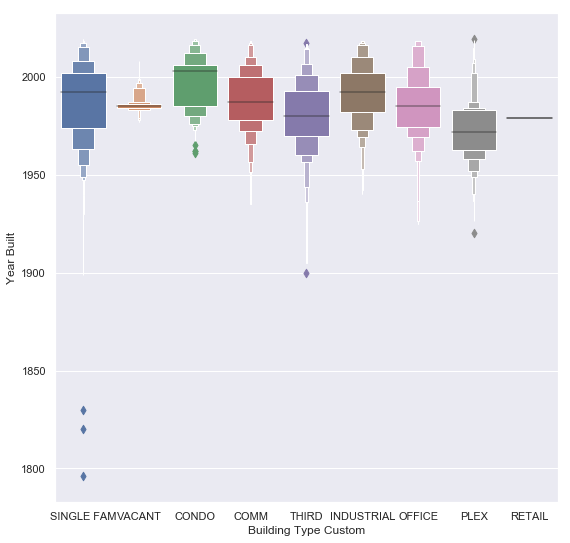

In [109]:
plt.figure(figsize=(9,9))
sns.boxenplot(y='Year Built', x = 'Building Type Custom', data = dfz8)

#Note the PLEX housing is the oldest.

In [7]:
df.nlargest(15,'NeighborhoodPPS')[['Neighborhood', 'Zone']]


,Neighborhood,Zone
154260,9527,2
153988,9527,2
154259,9527,2
137672,9527,2
153719,9527,2
154341,9527,2
153969,9527,2
154254,9527,2
279630,6264,9
279736,6264,9


CONDO         4410
SINGLE FAM     766
COMM           349
OFFICE         335
INDUSTRIAL     201
PLEX            86
THIRD           37
VACANT          14
RETAIL           1
Name: Building Type Custom, dtype: int64 (8700, 56)


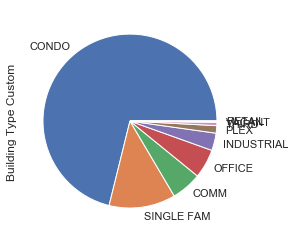

In [23]:
#Downtown zone. 
dfz9=df1[df1.Zone=='9']

dfz9['Building Type Custom'].value_counts().plot.pie()

print(dfz9['Building Type Custom'].value_counts(), dfz9.shape)

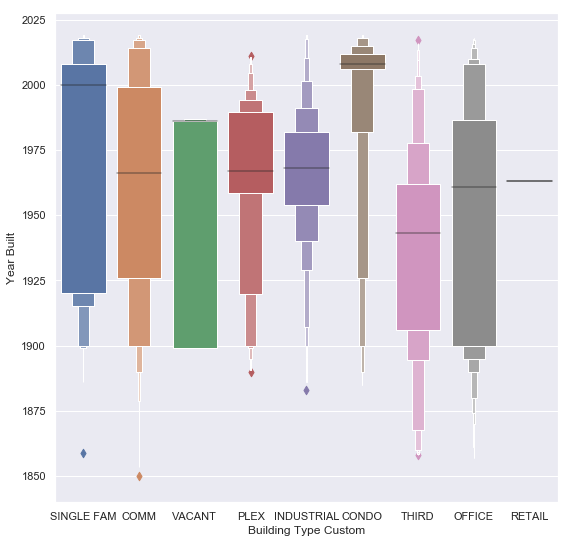

In [110]:
plt.figure(figsize=(9,9))
sns.boxenplot(y='Year Built', x = 'Building Type Custom', data = dfz9)
#Single family is the newest here.
#PLEX is the oldest

## Analyzing distribution of exterior wall among zones and possible effect on price

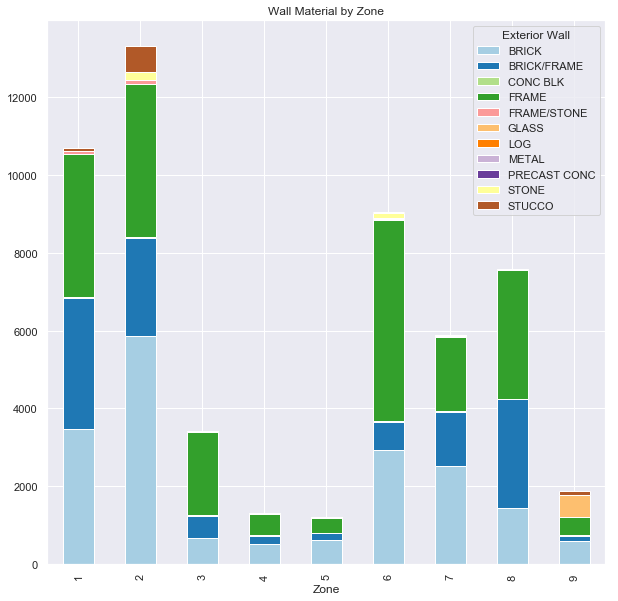

In [15]:
pd.crosstab(df.Zone, df['Exterior Wall']).plot(kind='bar',stacked=True, title= 'Wall Material by Zone', colormap='Paired', figsize=(10,10));

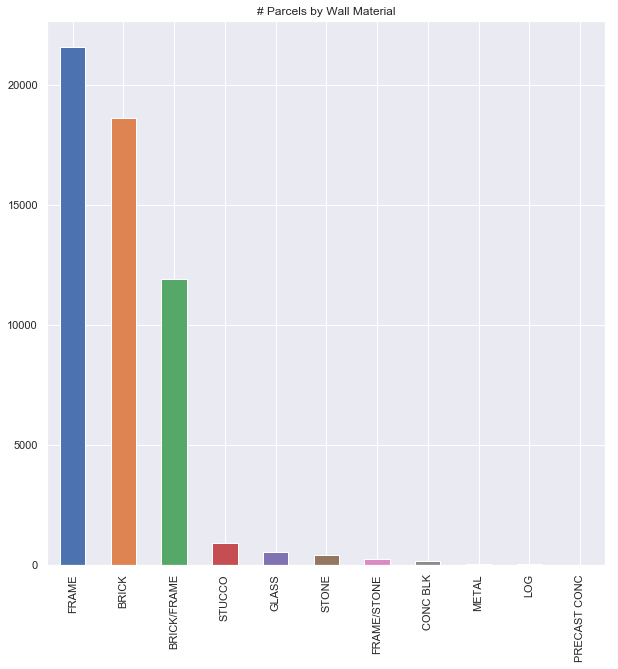

In [16]:
df['Exterior Wall'].value_counts().plot('bar', figsize=(10,10), title = '# Parcels by Wall Material')
#Nice distribution for analysis. Probably useful.

Text(0.5, 1.0, 'Price Distribution among Wall Types')

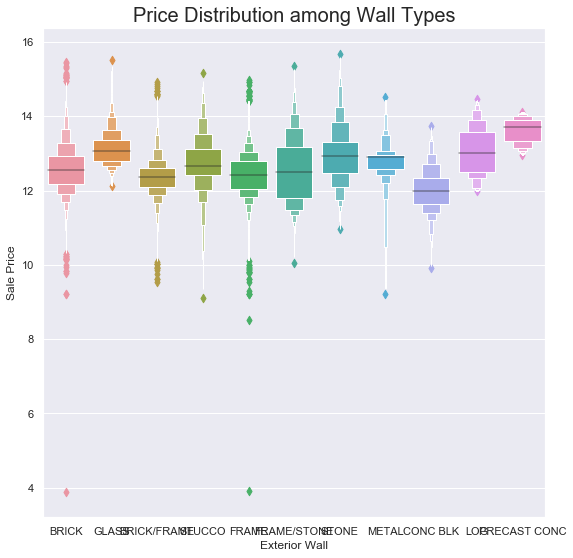

In [17]:
plt.figure(figsize=(9,9))
sns.boxenplot(x="Exterior Wall", y=np.log(df["Sale Price"]), data=df)
plt.title("Price Distribution among Wall Types", fontsize=20)
#Clearly concrete has the heighest average price. Stone is surprisingly low. Want to check PPS next.

Text(0.5, 1.0, 'Price Distribution among Wall Types')

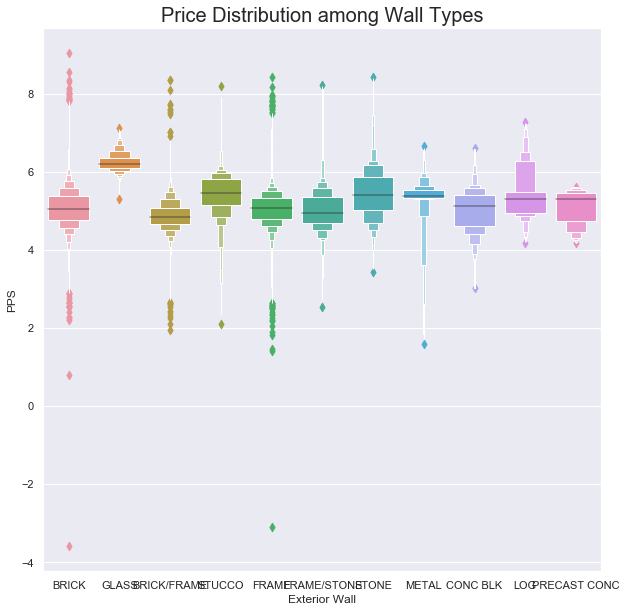

In [18]:
plt.figure(figsize=(10,10))
sns.boxenplot(x="Exterior Wall", y=np.log(df["PPS"]), data=df)
plt.title("Price Distribution among Wall Types", fontsize=20)


### Glass is the most expensive per square foot by far. 
### Normal 'Frame' (wood/stick frame?) and Brick have significant outliers, probably wealthy SFR.

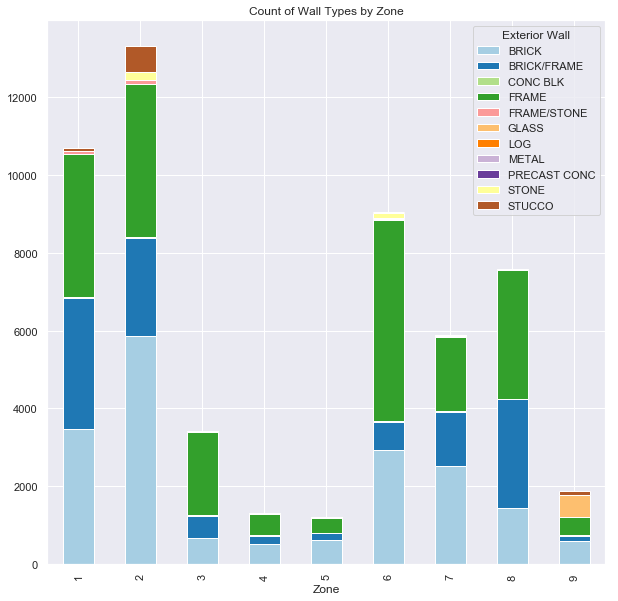

In [20]:
pd.crosstab(df.Zone,df['Exterior Wall']).plot(kind='bar',stacked=True, colormap='Paired', title = 'Count of Wall Types by Zone', figsize=(10,10))
#Why does Zone 2 have stucco? Also stone. How pricey are they?
#Only Zone 9 has glass.

Text(0.5, 1.0, 'Year Built of Different Wall Types')

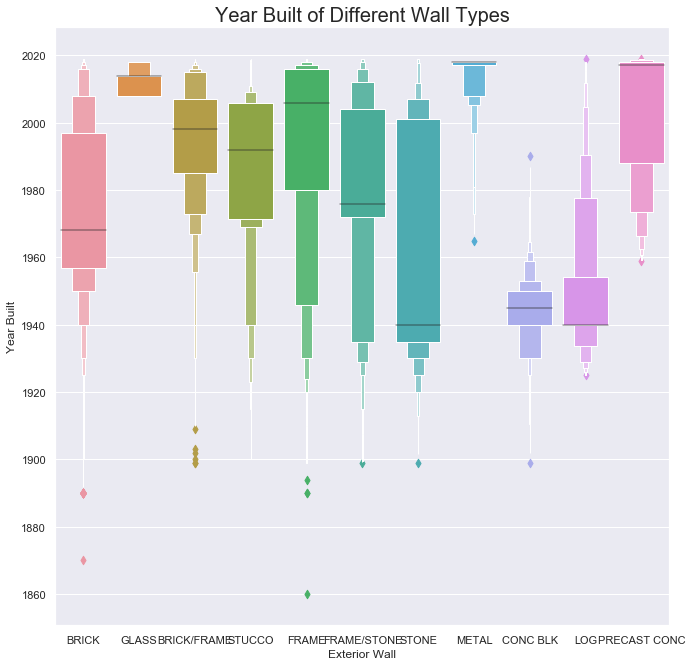

In [21]:
plt.figure(figsize=(11,11))
sns.boxenplot(y=df['Year Built'],x=df['Exterior Wall'])
plt.title('Year Built of Different Wall Types', fontsize=20)

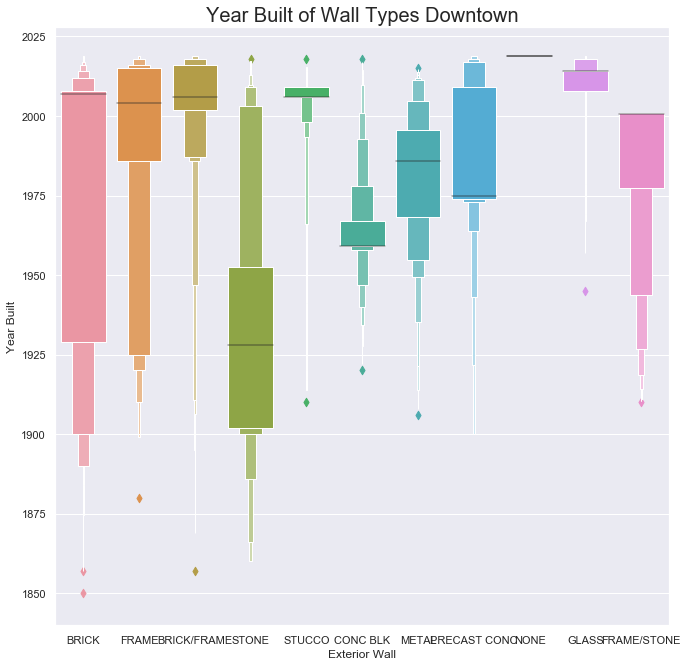

In [25]:
plt.figure(figsize=(11,11))
plt.title('Year Built of Wall Types Downtown', fontsize=20)
sns.boxenplot(x='Exterior Wall', y = 'Year Built', data = dfz9)

## Correlations and descriptions of various features

In [30]:
df['Frame Type'].value_counts()
#Not a great distribution. Probably not useful.

TYPICAL        21938
RESD FRAME     21838
COM WD FR         34
COM MASONRY       14
COM METAL          3
GOOD               2
Name: Frame Type, dtype: int64

In [7]:
df['Land Value Improved'].head(10)
#Adjacent parcels will often all have the same appraised land value. Appraised values are not generally useful for our purposes.

705    80000.0
707    80000.0
710    80000.0
711    80000.0
764    83200.0
781    65000.0
785    65000.0
791    65000.0
793    73700.0
794    73700.0
Name: Land Value Improved, dtype: float64

In [12]:
df['Tax District'].value_counts()
#Not a useful variable

USD     38375
GSD     15681
GO        680
GBID      498
CBID      459
FH        438
OH        378
BM        252
BH        103
Name: Tax District, dtype: int64

In [49]:
df[['Square Footage Improved', 'Most Recent Sale Price Improved']].corr()
#pd.plotting.scatter_matrix(df[['Square Footage Improved', 'Most Recent Sale Price Improved']], alpha= 0.5, diagonal='kde' )

,Square Footage Improved,Most Recent Sale Price Improved
Square Footage Improved,1.00000,0.57845
Most Recent Sale Price Improved,0.57845,1.00000


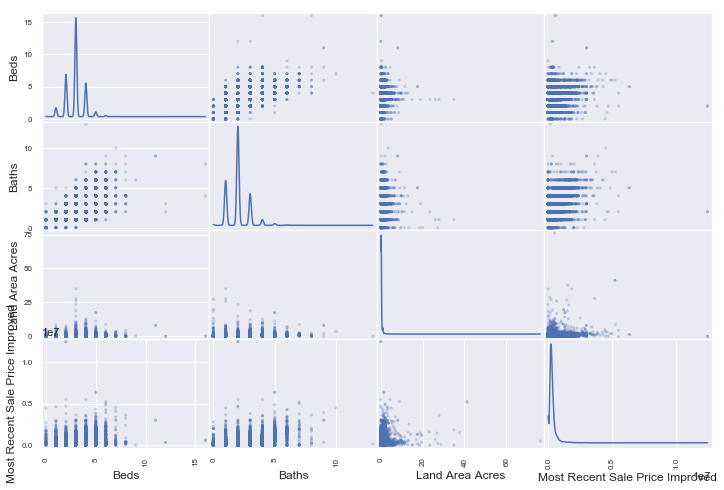

In [43]:
pd.plotting.scatter_matrix(df[['Beds','Baths', 'Land Area Acres','Most Recent Sale Price Improved']], alpha = 0.3,figsize = (12,8), diagonal = 'kde');

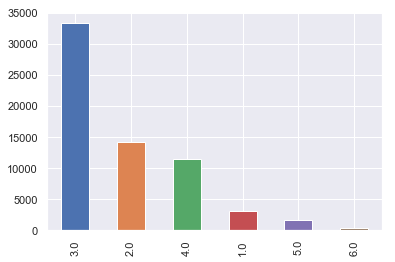

In [22]:
df.Beds.value_counts()[:6].plot('bar')

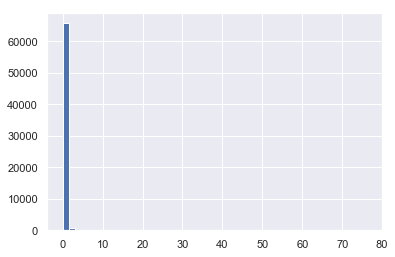

In [23]:
df['Land Area Acres'].hist(bins=50)
#We have some outliers, consider removing
#Important observation: the vsat majority of these units are multifamily (land area of 0)

In [20]:
df['Building Condition'].value_counts()
#I think this kind of class imbalance makes it useful for predictive purposes; if anything's different from 'Average' that's significant

Average        62780
Fair             709
Good             269
Poor             109
Very Good         49
Very Poor         34
Dilapidated       21
Excellent         11
Name: Building Condition, dtype: int64

In [19]:
df['Building Grade'].value_counts()
#We cannot use this variable. There is no guide on the Davidson CO site as to what these indicate.
#It is also safe to assume that, if you're a developer, you'll construct your new building in Grade A condition.

C      41733
B      16256
D       2528
A       2168
X       1121
E        112
TCC       14
SRB       12
SRC        8
OFB        6
OFD        3
AAC        2
ALB        2
OFC        2
TCD        2
IDC        2
TCB        2
SSD        2
TFC        1
SMD        1
SSC        1
ACB        1
IDD        1
ODB        1
SSB        1
Name: Building Grade, dtype: int64

In [65]:
print(df['Building Type Custom'].value_counts())

SINGLE FAM    37941
CONDO         13976
VACANT         1229
PLEX           1108
COMM             24
THIRD            17
OFFICE           10
INDUSTRIAL        2
Name: Building Type Custom, dtype: int64


## The 'Assessment Ratio'

Flirting with the idea of Assessment Improvement / Assessment Total ratio as a good predictor of PPS. Be warned this is only so useful because assessments are done after the property is built and use metrics derived from other data. However when averaged across the neighborhood it could show promise. Hypothesis: A neighborhood with low assessment ratio but high population density will get gentrified
    * McMansion neighborhoods will have a high-ish improvement assessment, on cheap land
    * Assessment very much depends on the time it was assessed so we will need to do a time series comparison to get valuable insight.
    * Want to plot meanpps neighborhoods with high assessment ratio

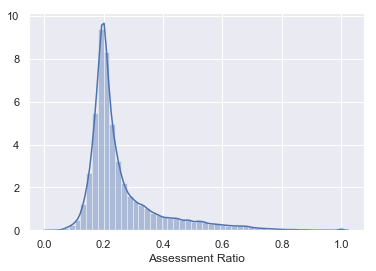

In [68]:
df['Assessment Ratio'] = df['Assessment Improvement Improved'] / df['Assessment Total Improved']
sns.distplot(df['Assessment Ratio'].dropna())

In [12]:
#Examining whether using Appraisal Value in the denominator might be better.
#Remember this feature must still be averaged across the neighborhood to provide value.
df['Ratio2'] = df['Assessment Improvement Improved'] / (df['Total Appraisal Value Improved'])

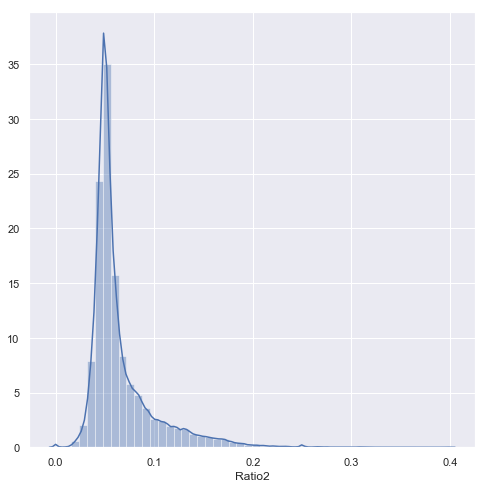

In [11]:
plt.figure(figsize=(8,8))
sns.distplot(df.Ratio2.dropna())

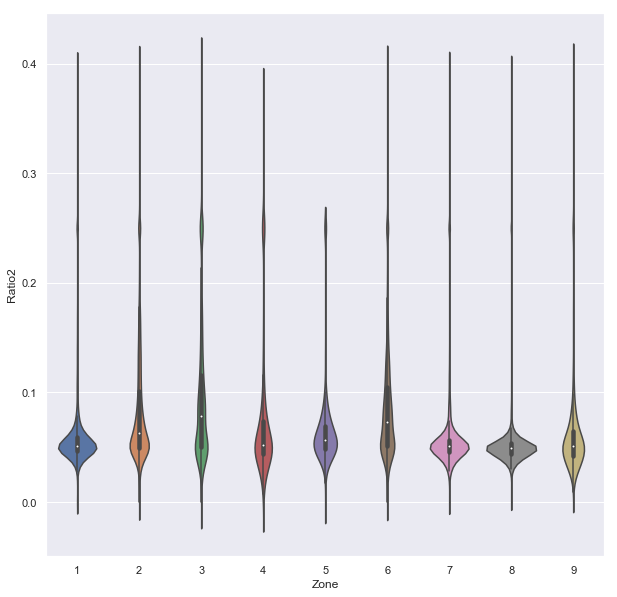

In [27]:
plt.figure(figsize=(10,10))
sns.violinplot(x='Zone', y = df['Ratio2'], data=df)

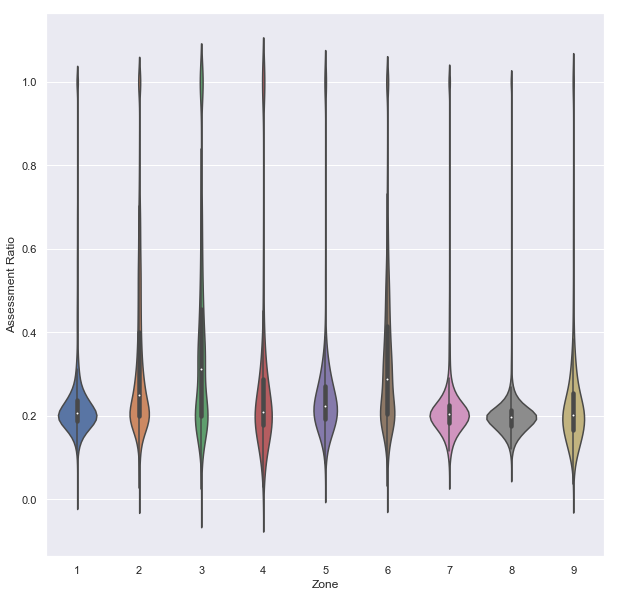

In [28]:
plt.figure(figsize=(10,10))
sns.violinplot(x='Zone', y = df['Assessment Ratio'], data=df)

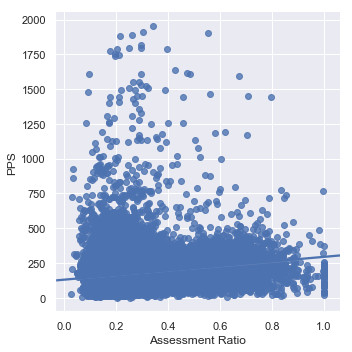

In [22]:
sns.lmplot(x='Assessment Ratio', y = 'PPS', data = df)
#Weak correlation.

In [21]:
ratioprice= pd.DataFrame(df[['Assessment Ratio', 'PPS', 'Year Built']])
ratioprice.corr()
#Weak correlation.

,Assessment Ratio,PPS,Year Built
Assessment Ratio,1.000000,0.208368,-0.40936
PPS,0.208368,1.000000,0.00837
Year Built,-0.409360,0.008370,1.00000


Text(0.5, 1.0, 'Square Footage vs PPS')

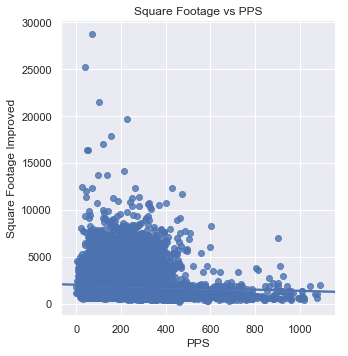

In [91]:
# plt.title('Square Footage vs Sale Price')

g = sns.lmplot("PPS", "Square Footage Improved", df)
plt.title("Square Footage vs PPS")

#Slight negative correlation

In [16]:
df['Property City'].value_counts(dropna=False)

NASHVILLE         40028
ANTIOCH            6459
HERMITAGE          3269
MADISON            2333
BRENTWOOD          1561
OLD HICKORY        1487
GOODLETTSVILLE      768
NOLENSVILLE         633
WHITES CREEK        120
MOUNT JULIET        115
NaN                  79
JOELTON              11
UNKNOWN               1
Name: Property City, dtype: int64

1.00    25726
2.00    20466
1.50     3716
1.75     2249
3.00     1438
1.25      371
2.50      131
2.25       76
2.75       51
4.00        9
Name: Story Height, dtype: int64


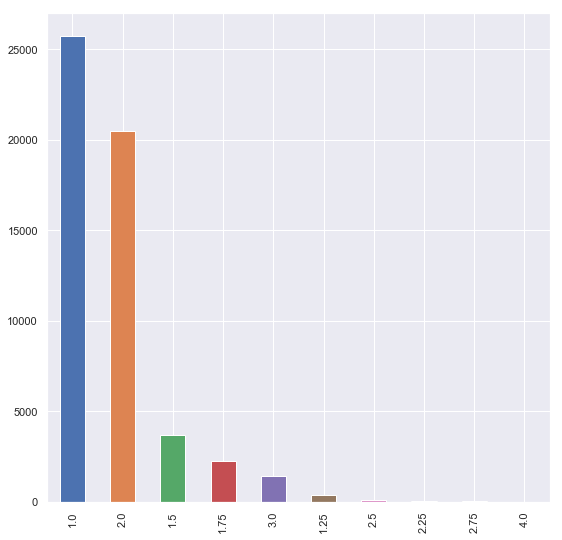

In [92]:
print(df['Story Height'].value_counts())
df['Story Height'].value_counts().plot('bar', figsize=(9,9), title= ''

In [20]:
df['Sold As Vacant'].value_counts()
#Not useful.

No     55755
Yes     1109
Name: Sold As Vacant, dtype: int64

### Interesting feature: Fixtures 
Fixtures are permanently-attached water fixtures such as baths, sinks, and toilets. They could reveal a lot about the price of the house. I'd consider Half Bath or Fixtures in the ML model.


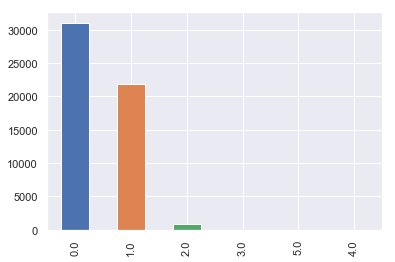

In [61]:
#This is a strong potential indicator of PPS. But Fixtures might be better.
df['Half Bath'].value_counts().plot('bar')

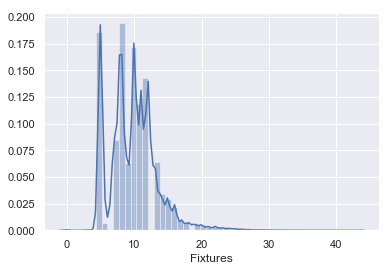

In [29]:
sns.distplot(df['Fixtures'].dropna())

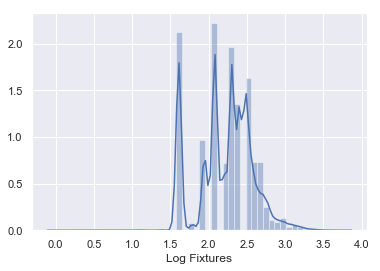

In [32]:
#It is slightly right-skewed. Does a log-transformation help?
df['Log Fixtures']= df['Fixtures'].map(lambda x: np.log(x) if (pd.notnull(x) and x != 0) else None)
df['Log Fixtures']=df['Log Fixtures'].replace(np.inf, np.nan)
sns.distplot(df['Log Fixtures'].dropna())

## Examining which types of buildings were built through time.

An area graph (time series) would be helpful here.

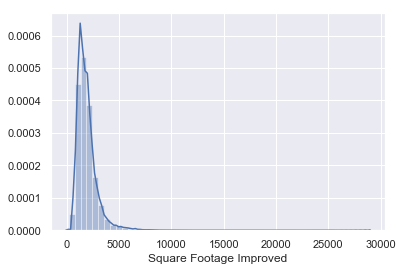

In [85]:
sns.distplot(df['Square Footage Improved'].dropna())
# We have some serious outliers here. Let's investigate in the next cell.

In [68]:
df.nlargest(20, 'Square Footage Improved')[['Map & Parcel','Building Type Custom','Square Footage Improved', 'Location', 'Sale Price', 'PPS']]

,Map & Parcel,Building Type Custom,Square Footage Improved,Location,Sale Price,PPS
71926,082 15 0 204.00,THIRD,28743.0,518 RUSSELL ST,2000000.0,69.582159
164560,142 00 0 109.00,THIRD,25193.0,215 BELLEVUE RD,950000.0,37.708887
45785,070 06 0 050.00,THIRD,21518.0,1230 W TRINITY LN,2200000.0,102.239985
169777,144 00 0 012.00,SINGLE FAM,19728.0,6123 HILLSBORO PIKE,4500000.0,228.102190
133741,117 11 0 028.00,COMM,17875.0,2001 WOODMONT BLVD,2780000.0,155.524476
87245,091 10 0 275.00,THIRD,17072.0,5701 ROBERTSON AVE,2000000.0,117.150890
146739,129 08 0 084.00,OFFICE,16356.0,6200 HIGHWAY 100,850000.0,51.968697
75125,083 08 0 062.00,THIRD,16355.0,901 DALEBROOK LN,800000.0,48.914705
149650,130 13 0 055.00,SINGLE FAM,14143.0,1308 PAGE RD,3000000.0,212.119070
171332,146 02 0 021.00,SINGLE FAM,13730.0,4901 TYNE VALLEY BLVD,1846875.0,134.513838


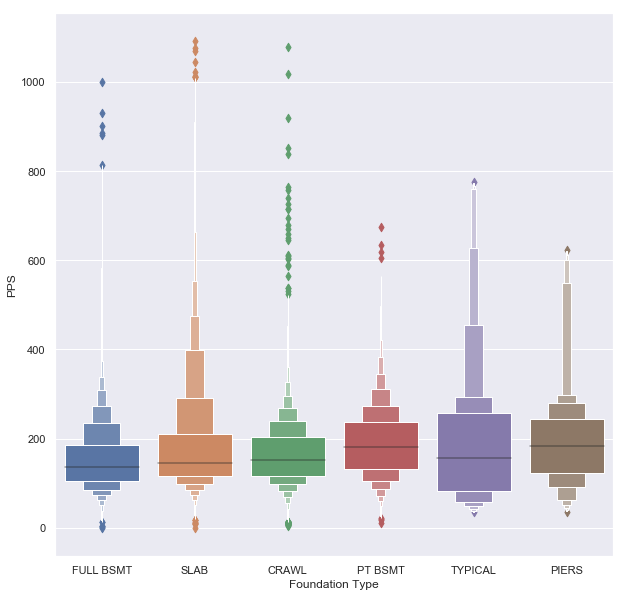

In [71]:
df['Foundation Type'].value_counts()
plt.figure(figsize=(10,10))
sns.boxenplot(x='Foundation Type', y = 'PPS', data=df)
#I wouldn't say there's anything valuable here, but it's good to keep for reference.

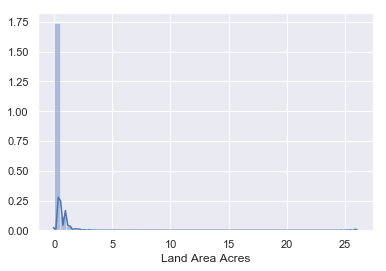

In [86]:
sns.distplot(df['Land Area Acres'])

In [87]:
df['Land Area Acres'].quantile([.9, .95, .997])

0.900    0.50000
0.950    0.95000
0.997    3.27304
Name: Land Area Acres, dtype: float64

In [111]:
#What is the distribution of Plexes like? Is it linked to higher property values?
plex= df1[df1['Building Type Custom']=='PLEX']
plex.describe()

,Unnamed: 0,Assessment Year,Baths,Beds,Fixtures,Half Bath,Number of Living Units,Rooms,Story Height,Year Built,Sale Price,Assessment Improvement Improved,Most Recent Sale Price Improved,Improvement Value Improved,Assessment Total Improved,Land Value Improved,Assessment Land Improved,Total Appraisal Value Improved,Square Footage Improved,Land Area Acres
count,8677.000000,8677.0,8677.000000,8676.000000,8676.000000,8632.000000,8677.000000,8676.000000,8677.000000,8677.000000,1.428000e+03,8677.000000,8.677000e+03,8.677000e+03,8.677000e+03,8.677000e+03,8677.000000,8.677000e+03,8677.000000,8677.000000
mean,93329.634436,2019.0,2.475510,4.100622,11.544030,0.079472,2.113403,8.647418,1.252449,1962.973147,3.632959e+05,35934.096116,1.765434e+05,1.328188e+05,8.105679e+04,1.053972e+05,35934.096116,2.382160e+05,1990.435980,0.389776
std,53058.780464,0.0,0.856056,1.169603,2.982759,0.383515,0.407741,2.109139,0.401327,21.238700,6.319037e+05,36261.654395,5.540336e+05,1.348169e+05,6.746830e+04,1.108981e+05,36261.654395,1.977529e+05,678.833091,1.016053
min,844.000000,2019.0,0.000000,0.000000,5.000000,0.000000,1.000000,0.000000,1.000000,1890.000000,2.650000e+04,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000
25%,53286.000000,2019.0,2.000000,4.000000,10.000000,0.000000,2.000000,8.000000,1.000000,1950.000000,1.450000e+05,12400.000000,0.000000e+00,8.460000e+04,4.736000e+04,3.400000e+04,12400.000000,1.326000e+05,1537.000000,0.190000
50%,87590.000000,2019.0,2.000000,4.000000,10.000000,0.000000,2.000000,8.000000,1.000000,1966.000000,2.099000e+05,21300.000000,6.500000e+04,1.093000e+05,6.428000e+04,6.200000e+04,21300.000000,1.837000e+05,1806.000000,0.250000
75%,131913.000000,2019.0,3.000000,4.000000,13.000000,0.000000,2.000000,10.000000,1.500000,1981.000000,3.400000e+05,48875.000000,1.509000e+05,1.521000e+05,9.904000e+04,1.500000e+05,48875.000000,2.938000e+05,2218.000000,0.370000
max,281736.000000,2019.0,12.000000,18.000000,40.000000,10.000000,4.000000,28.000000,3.000000,2019.000000,6.500000e+06,642960.000000,1.470000e+07,9.099300e+06,3.866920e+06,3.757000e+06,642960.000000,9.667300e+06,8559.000000,57.660000


## Going forward: next analysis

Next we'll need extensive time series modeling.
Hopefully when analysis is more organized we can use statsmodels to examine the effect of different features. 
i.e. How much will consumers pay for one extra bedroom?


In [38]:
df.nlargest(20,'NeighborhoodPPS')['Neighborhood']

133742    3211
279631    6264
279737    6264
279659    6264
279602    6264
279632    6264
279617    6264
279656    6264
279679    6264
279657    6264
279743    6264
279658    6264
279690    6264
279740    6264
279717    6264
279674    6264
279646    6264
279714    6264
279732    6264
279685    6264
Name: Neighborhood, dtype: object

In [39]:
df.loc[279657]

Assessment Classification*                                              RES
Assessment Improvement                                              $87,325
Assessment Land                                                     $33,750
Assessment Total                                                   $121,075
Assessment Year                                                        2019
Baths                                                                     1
Beds2                                                                   NaN
Building Condition                                                  Average
Building Grade2                                                         NaN
Building Type                                                   HRISE CONDO
Building Type2                                                          NaN
Current Owner                                PFEIFFER, MATTHEW R. & WHITNEY
Deed Reference                                             20180502-0041538
Exterior Wal